In [2]:
import torch
import torch.nn as nn

卷积神经网络建立在卷积运算的基础上，通过融合局部感受野内的空间信息和通道信息来提取信息特征。
为了提高网络的表示能力，许多现有的工作通过在  空间维度  上对网络的性能进行了提升，
        比如Inception模块中嵌入多尺度处理来提高准确度，Spatial Transformer Networks（STN）结合空间注意力机制。

# SE 模块 , Squeeze-and-Excitation module
通过学习的方式来自动获取 每个通道 的重要程度，然后依照这个重要程度去提升有用的特征并抑制对当前任务用处不大的特征。
给定输入x，通道数为c1，经过一系列卷积后变为c2，接下来通过SE模块的三个操作来重标定前面得到的特征：

1. Squeeze 压缩：
    沿空间维度压缩，将每个channel的二维特征变为一个实数，可以理解为 对每个channel的特征信息融合，这个实数具有全局的感受野，且输出的维度和输入的特征channel数相匹配。它表征在特征channel上相应的全局分布，使得靠近 输入 的层也可以获得全局感受野，！！！！！！！！
    通过全局平均池化 GAP 实现，输出为 1*1*c

2. Excitation 激励：
    得到Squeeze的1*1*c 全局特征后，通过 全连接层 对每个channel的重要性进行预测，类似于RNN中 门的机制，由参数生成channel的权重，其中参数被用来显式的建模通道间的相关性
    计算中为了降低计算量，设置了 缩放参数 SERatio：
        第一个全连接层有 C*SERatio 个神经元，输入为 1×1×C，输出1×1×C×SERadio，起到降维作用。 
        第二个全连接层有C个神经元，输入为1×1×C×SERadio，输出为1×1×C

3. Scale 缩放：
    将 Excitation  的输出权重看作  经过特征选择后的每个channel 的重要性，通过 乘法 逐通道加权到原先的特征上，完成在 通道维度 对原始特征的重标定！

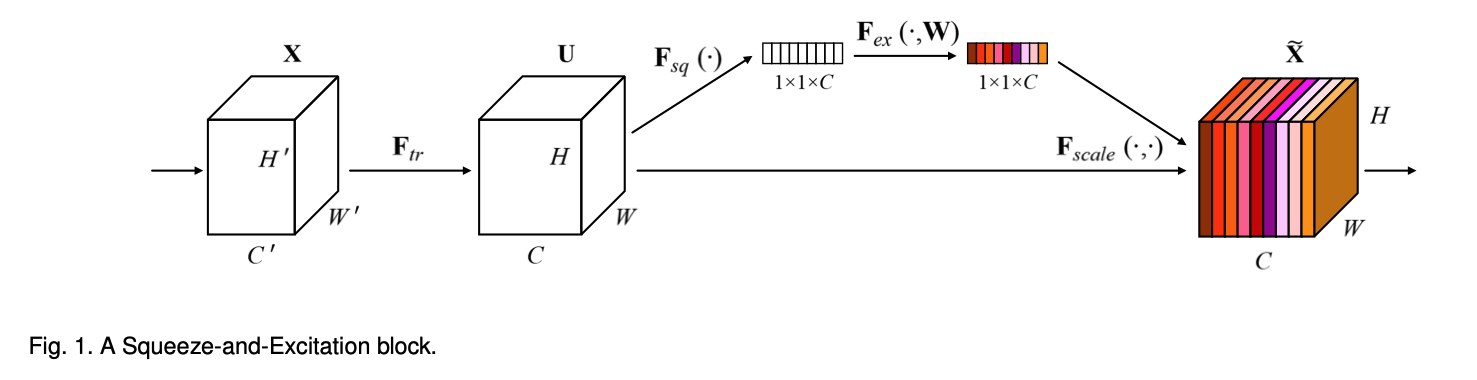

In [6]:
## 方法4 
from IPython.display import Image, display
 
img_path = 'SE-block.png'
display(Image(filename=img_path))


In [ ]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# CBAM 模块，Convolutional Block Attention Module 
    给定一个中间特征图，我们的模块会沿着两个独立的维度（通道和空间）依次推断注意力图，然后将 注意力图 乘以 输入特征图 以进行自适应特征修饰。 
    由于CBAM是轻量级的通用模块，因此可以以可忽略的开销将其无缝集成到任何CNN架构中，并且可以与基础CNN一起进行端到端训练。
1. CAM  channel Attention module
    - 将输入的特征图 F（H×W×C）分别经过global max pooling（全局最大池化）和global average pooling（全局平均池化），得到两个1×1×C的特征图，
    - 接着，再将它们分别送入一个两层的神经网络（MLP），第一层神经元个数为 C/r（r为减少率），激活函数为 Relu，第二层神经元个数为 C，这个两层的神经网络是共享的。
    - 而后，将MLP输出的特征进行基于element-wise的 加和操作，再经过sigmoid激活操作，生成最终的channel attention feature，即 M_c。
    - 最后，将M_c 和 输入特征图F 做element-wise 乘法操作，生成Spatial attention模块需要的输入特征。
    (avg & max 的并行连接方式比单一的池化丢失的信息更少，所以效果会更好一点。)


2. SAM  spatial attention module
    - 将Channel attention模块输出的特征图F’作为本模块的输入特征图。
    - 首先做一个基于channel的 global max pooling 和global average pooling，得到 两个H×W×1 的特征图，
    - 然后将这2个特征图基于channel做 concat操作（通道拼接），之后经过一个7×7卷积（7×7比3×3效果要好）操作，降维为1个channel，即 H×W×1。
    - 再经过sigmoid生成spatial attention feature，即M_s。
    - 最后，将M_s和 该模块的输入feature 做乘法，得到最终生成的特征。

3. CAM和SAM的组合方式，并行或者串行，发现 先通道再空间 （CAM+SAM）的结果会稍微好一点

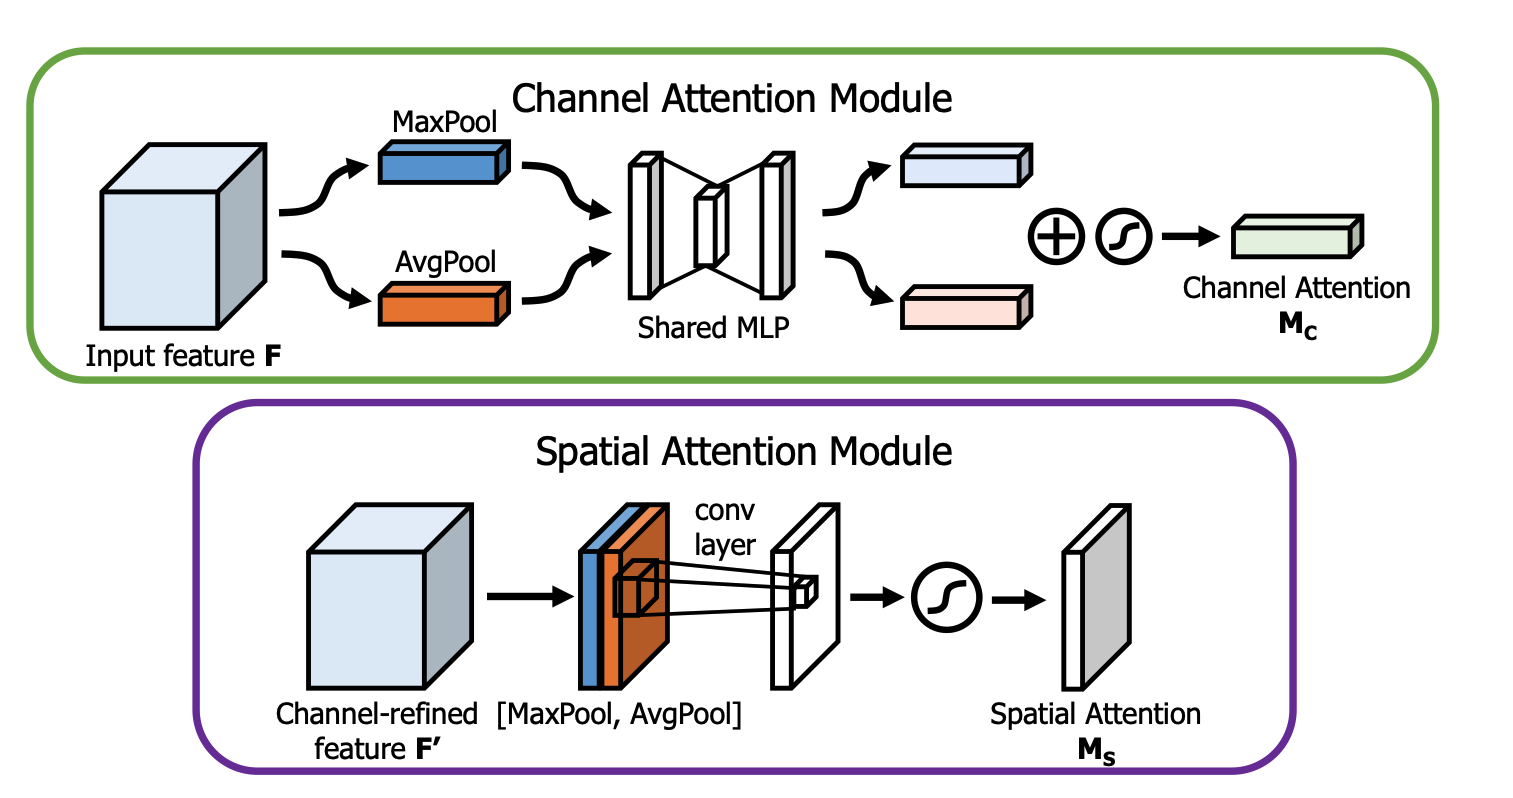

In [7]:
img_path = 'CBAM.png'
display(Image(filename=img_path))

In [3]:
class ChannelAttention(nn.Module):
   def __init__(self, channels, reduction_radio=16):
    super().__init__()
    self.channels = channels
    self.inter_channels = self.channels // reduction_radio
    self.maxpool = nn.AdaptiveMaxPool2d((1, 1))
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    
    self.mlp = nn.Sequential( # 使用1x1卷积代替线性层，可以不用调整tensor的形状
        nn.Conv2d(self.channels, self.inter_channels,
                  kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(self.inter_channels),
        nn.ReLU(),
        nn.Conv2d(self.inter_channels, self.channels,
                  kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(self.channels))
    self.sigmoid = nn.Sigmoid()

    def forward(self, x): # (b, c, h, w)
        maxout = self.maxpool(x) # (b, c, 1, 1)
        avgout = self.avgpool(x) # (b, c, 1, 1)

        maxout = self.mlp(maxout) # (b, c, 1, 1)
        avgout = self.mlp(avgout) # (b, c, 1, 1)

        attention = self.sigmoid(maxout + avgout) #(b, c, 1, 1)
        return attention

In [4]:
class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=2, out_channels=1,
                kernel_size=7, stride=1, padding=3)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x): # (b, c, h, w)
        maxpool = x.argmax(dim=1, keepdim=True) # (b, 1, h, w)
        avgpool = x.mean(dim=1, keepdim=True)   # (b, 1, h, w)

        out = torch.cat([maxpool, avgpool], dim=1) # (b, 2, h, w)
        out = self.conv(out)  # (b, 1, h, w)

        attention = self.sigmoid(out) #(b, 1, h, w)
        return attention

In [5]:
class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)
 
    def forward(self, x):
        out = x * self.ca(x)
        result = out * self.sa(out)
        return result

In [6]:
x = torch.randn(1, 1024, 32, 32)
net = CBAM(1024)
out = net.forward(x)
criterion = nn.L1Loss()
loss = criterion(out, x)
loss.backward()
# 最终输出特征图V的size和损失值
print('out shape : {}'.format(out.shape))
print('loss value : {}'.format(loss))

out shape : torch.Size([1, 1024, 32, 32])
loss value : 0.5070571303367615


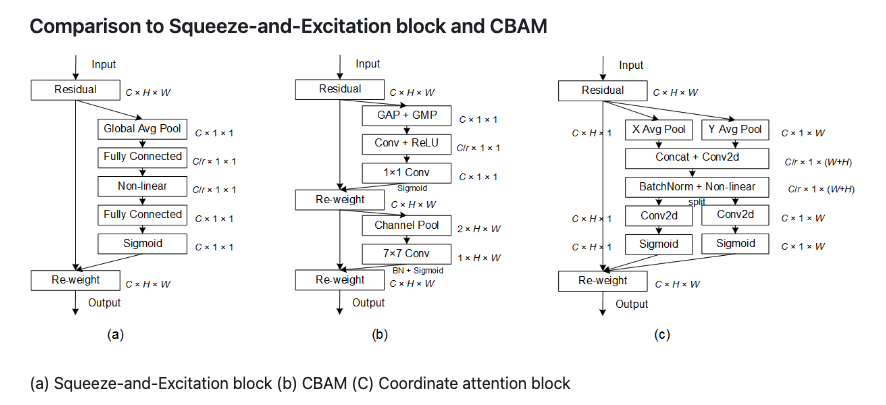

In [2]:
## 方法4 
from IPython.display import Image, display

img_path = 'SE-CBAM-CA.png'
display(Image(filename=img_path))

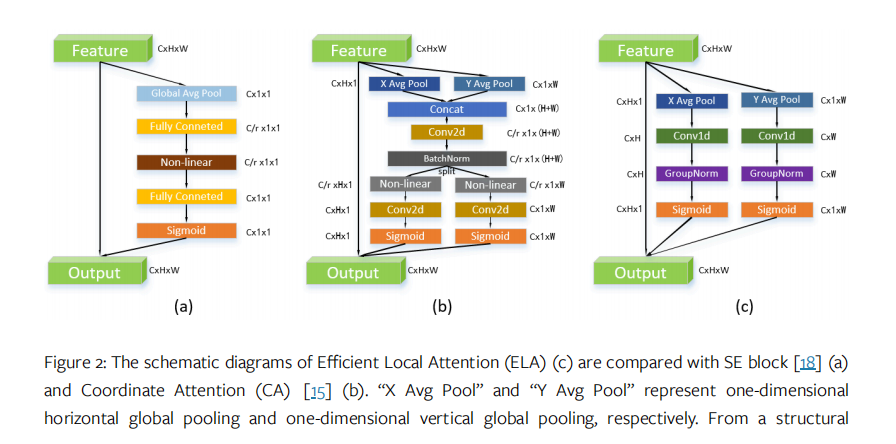

In [3]:

img_path = 'SE-CA-ELA.png'
display(Image(filename=img_path))